In [26]:
import tensorflow
import tensorflow.keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, ReLU, Input, MaxPooling1D
from tensorflow.keras.models import Sequential

import numpy as np
import time

LOAD DATABASES, CONCATENATE AND MIX THEM

In [45]:
#path_db_0 = '/scratch/scarpolini/databases/db_lorenz_20.0_27.5.npy'
#path_labels_0 = '/scratch/scarpolini/databases/lorenz_labels_20.0_27.5.npy'
#path_db_1 = '/scratch/scarpolini/databases/db_lorenz_29.0_50.0.npy'
#path_labels_1 = '/scratch/scarpolini/databases/lorenz_labels_29.0_50.0.npy'
#path_db_2 = '/scratch/scarpolini/databases/db_lorenz_22.5_26.0.npy'
#path_labels_2 = '/scratch/scarpolini/databases/lorenz_labels_22.5_26.0.npy'
#path_db_3 = '/scratch/scarpolini/databases/db_lorenz_10.0_50.0.npy'
#path_labels_3 = '/scratch/scarpolini/databases/lorenz_labels_10.0_50.0.npy'
#
#db1 = np.load(path_db_2)
#labels1 = np.load(path_labels_2)
#db2 = np.load(path_db_0)
#labels2 = np.load(path_labels_0)
#db = np.ndarray(shape=(200000,2000,1))
#db[:100000,:,0] = db1[:,:,0]
#db[100000:,:,0] = db2[:,:,0]
#labels = np.ndarray(shape=(200000))
#labels[:100000] = labels1[:]
#labels[100000:] = labels2[:]
#
#del db1, db2
sss = time.time()
rv = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0]
nr = len(rv)
paths = []
for r in rv:
    paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")

n_traj = 50000
db = np.ndarray(shape=(nr*n_traj,2000,1))
labels = []
for path,r,i in zip(paths,rv,range(nr)):
    db1 = np.load(path)
    for j in range(n_traj):
        db[i*n_traj + j,:,0] = db1[j,0,:]
        labels.append(r)

labels = np.array(labels)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

db, labels = unison_shuffled_copies(db, labels)
print(f'time: {time.time() - sss:.1f}')

time: 19.0


CONVERTO LABELS PER DEFINIRE LE CLASSI

In [54]:
ll = []
for label in labels :
    if label in rv :
        ll.append(rv.index(label))
    else: print('problem')
labels = ll

PREPROCESSING

In [55]:
#(db_train), (db_test) = db[:80000,:,:], db[80000:,:,:]
# Normalize to between -1 and 1
#db = db[:,:,0:1]
print(db.shape)
M = np.max(db)
m = np.min(db)
print(M,m)
db = (db - m)/(M - m)
M = np.max(db)
m = np.min(db)
print(M,m)

(300000, 2000, 1)
33.45311378674468 -33.45763272036239
1.0 0.0


VISUALIZE DATA

60012
60.0


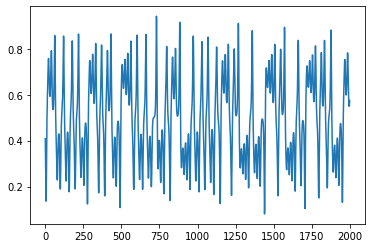

In [75]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
%matplotlib inline

n = round(np.random.uniform(100000))
#n = 35368
print(n)
traj = db[n,:,:]
print(rv[labels[n]])
plt.plot(traj[:,0])
#plt.plot(traj[:,1])
#plt.plot(traj[:,2])
plt.show()

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot3D(traj[:,0],traj[:,1],traj[:,2])

ARCHITETTURA RETE NEURALE

In [76]:
optimizer = Adam(0.0002, 0.5)
sig_len, channels = len(db[0,:,0]), len(db[0,0,:])
fs = 10 # dimensione filtro
fm = 32 # numero filtri
init_sigma = 0.02 # varianza distribuzione parametri iniziali dei kernel
def create_desc():
    discriminator = Sequential()
    #input:2000x1
    discriminator.add(Conv1D(fm, fs, strides=4, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02), input_shape=(sig_len, channels)))    
    discriminator.add(Dropout(0.1))
    #input:500x32
    discriminator.add(Conv1D(fm, fs, strides=2, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02)))    
    discriminator.add(Dropout(0.1))
    #input:250x32
    #discriminator.add(Conv1D(fm, fs, strides=1, padding='same', activation='relu', kernel_initializer=RandomNormal(0, 0.02)))    
    #input:250x64
    discriminator.add(Flatten())
    #8000x1
    discriminator.add(Dense(250*fm, activation='relu'))
    #discriminator.add(Dropout(0.1))
    discriminator.add(Dense(4, activation='softmax'))
    #discriminator.add(Dropout(0.1))
    #4x1
    discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return discriminator

desc = create_desc()

W0324 21:03:22.782276 47430657170944 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0324 21:03:22.917283 47430657170944 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [77]:
desc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 500, 32)           352       
_________________________________________________________________
dropout (Dropout)            (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 32)           10272     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 8000)              64008000  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 4

TRAINING

In [11]:
#desc = create_desc()
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
fit_history = desc.fit(db, labels, batch_size=256, epochs=5, verbose=1, validation_split=0.33,
                       shuffle=False, callbacks=[history])

Train on 134000 samples, validate on 66000 samples
Epoch 1/5
134000/134000 [==============================] - 15s 110us/sample - loss: 0.3989 - acc: 0.8177 - val_loss: 0.1131 - val_acc: 0.9413
Epoch 2/5
134000/134000 [==============================] - 13s 95us/sample - loss: 0.0763 - acc: 0.9681 - val_loss: 0.0448 - val_acc: 0.9786
Epoch 3/5
134000/134000 [==============================] - 13s 95us/sample - loss: 0.0233 - acc: 0.9919 - val_loss: 0.0081 - val_acc: 0.9979
Epoch 4/5
134000/134000 [==============================] - 13s 95us/sample - loss: 0.0100 - acc: 0.9969 - val_loss: 0.0089 - val_acc: 0.9970
Epoch 5/5
134000/134000 [==============================] - 13s 94us/sample - loss: 0.0116 - acc: 0.9962 - val_loss: 0.0084 - val_acc: 0.9974


In [12]:
desc.save('classificatore.h5')
#from tensorflow.keras.models import load_model
#desc = load_model('classificatore.h5')

TESTING

In [280]:
#n = round(np.random.uniform(0,10000))
desc.evaluate(db,labels)
#output = desc.predict(db[n:n+1000])
#for i in range(100):
#    print(f'{n+i:4}',end="\t")
#    print(f'{output[i][0]:1.2g}',end="\t")
#    print(f'{output[i][1]:1.2g}',end="\t")
#    print(f'{labels[n+i]:3}')

100000/100000 [==============================] - 6s 60us/sample - loss: 0.0028 - acc: 1.0000


[0.002768268127478659, 0.99999]

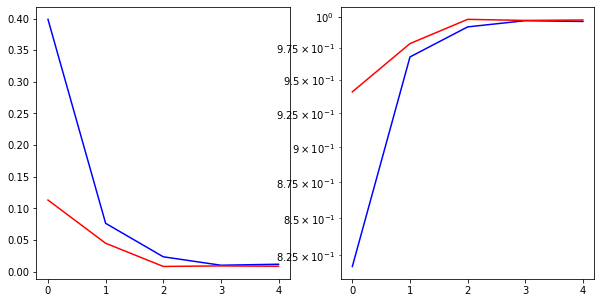

In [13]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
epoch = fit_history.history
#epoch = fit_history.history
plt.yscale('log')
ax1.plot(epoch['loss'], color="b")
ax1.plot(epoch['val_loss'], color="r")
ax2.plot(epoch['acc'], color="b")
ax2.plot(epoch['val_acc'], color="r")

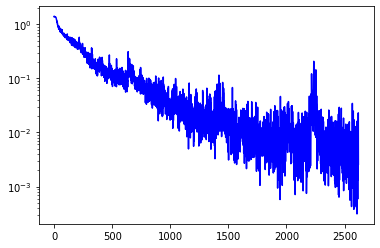

In [14]:
#fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
#epoch = fit_history.history
losses = history.losses
val_losses = history.val_losses
plt.yscale('log')
plt.plot(losses, color="b")
plt.plot(val_losses, color="r")
#ax2.plot(epoch['acc'], color="b")
#ax2.plot(epoch['val_acc'], color="r")

In [53]:
a = desc.get_weights()
for i in range(8): 
    print( a[i].shape )

(10, 1, 32)
(32,)
(10, 32, 32)
(32,)
(8000, 8000)
(8000,)
(8000, 4)
(4,)


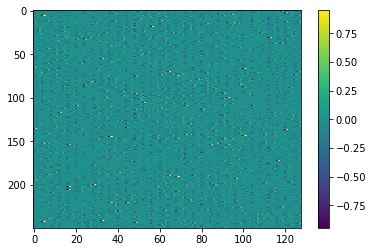

In [99]:
ciccio = a[6].reshape(250,-1)
import matplotlib.pyplot as plt
plt.imshow(ciccio, aspect="auto")
plt.colorbar()